In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.nn as nn
import time
import os

from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Activation, Average, BatchNormalization, Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAvgPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib
from tensorflow.python.ops.batch_ops import Batch
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9626337555364306198
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14401011712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15114484345549836631
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [4]:
tf.__version__

'2.11.0'

#### Load data

In [5]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
# установка параметров нейросети
batch_size = 128
num_classes = 10
epochs = 15

result = pd.DataFrame() # сводная таблица результатов
net_name = [] # название сети
train_accuracy = [] # результат на трейне
test_accuracy = [] # результат на тесте

classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

# разделение тренировочной и тестовой выборки
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [6]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'тренировочные примеры')
print(X_test.shape[0], 'тестовые примеры')

X_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


In [7]:
# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

X_train = X_train / 255.0
X_test = X_test / 255.0

<function matplotlib.pyplot.show(*args, **kw)>

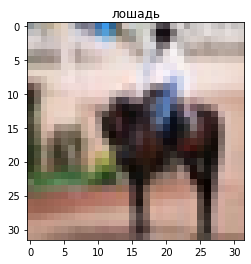

In [8]:
plt.imshow(X_train[11])
plt.title(classes[np.argmax(y_train[11,:])])
plt.show

#### Basic model training

In [9]:
input_basic = Input(X_train.shape[1:])
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_basic)
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.25)(x)
out_basic = Dense(num_classes, activation='softmax')(x)

model_basic = Model(inputs=input_basic, outputs=out_basic)

model_basic.summary()

# model compile
model_basic.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                             

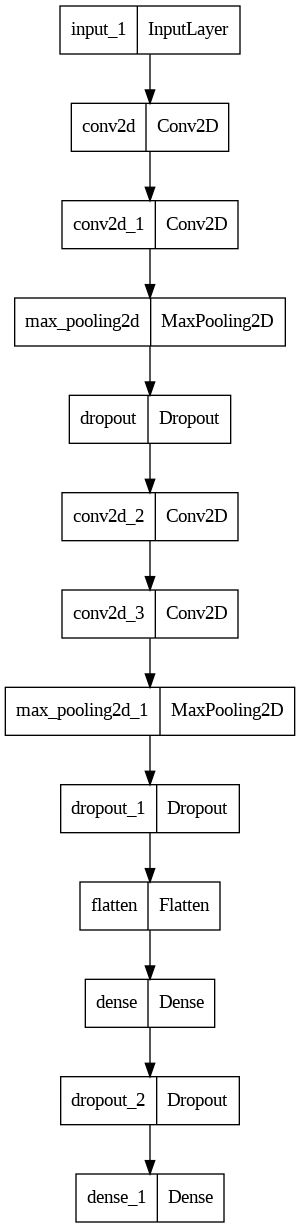

In [10]:
plot_model(model_basic,to_file='basic.png')

In [11]:
history_basic = model_basic.fit(X_train, y_train, batch_size=batch_size, 
                                epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
391/391 [==============================] - 17s 17ms/step - loss: 1.8196 - accuracy: 0.3263 - val_loss: 1.3860 - val_accuracy: 0.5102
Epoch 2/15
391/391 [==============================] - 6s 16ms/step - loss: 1.4126 - accuracy: 0.4876 - val_loss: 1.1772 - val_accuracy: 0.5816
Epoch 3/15
391/391 [==============================] - 6s 15ms/step - loss: 1.2489 - accuracy: 0.5480 - val_loss: 1.0272 - val_accuracy: 0.6308
Epoch 4/15
391/391 [==============================] - 6s 15ms/step - loss: 1.1431 - accuracy: 0.5906 - val_loss: 0.9632 - val_accuracy: 0.6553
Epoch 5/15
391/391 [==============================] - 6s 15ms/step - loss: 1.0797 - accuracy: 0.6147 - val_loss: 0.9160 - val_accuracy: 0.6748
Epoch 6/15
391/391 [==============================] - 6s 16ms/step - loss: 1.0156 - accuracy: 0.6364 - val_loss: 0.8595 - val_accuracy: 0.6999
Epoch 7/15
391/391 [==============================] - 6s 15ms/step - loss: 0.9745 - accuracy: 0.6538 - val_loss: 0.8199 - val_accuracy: 0.712

In [12]:
train_loss, train_m = model_basic.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_basic.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('Basic')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 5s - loss: 0.5051 - accuracy: 0.8290 - 5s/epoch - 3ms/step
313/313 - 1s - loss: 0.6886 - accuracy: 0.7613 - 1s/epoch - 4ms/step
train_loss: 0.5050813555717468, train_accuracy: 0.829039990901947
test_loss: 0.6885728240013123, test_accuracy: 0.7613000273704529


#### Increasing the network width

In [13]:
input_width = Input(X_train.shape[1:])
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_width)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.25)(x)
out_width = Dense(num_classes, activation='softmax')(x)

model_width = Model(inputs=input_width, outputs=out_width)

model_width.summary()

# model compile
model_width.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 256)       147712    
                                                           

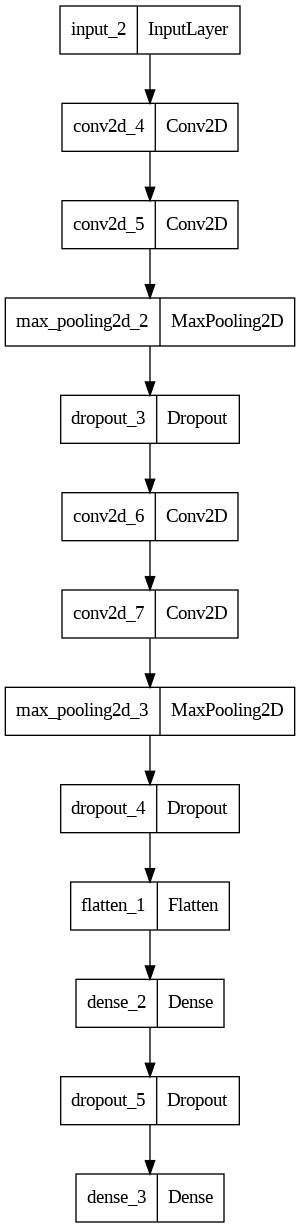

In [14]:
plot_model(model_width,to_file='width.png')

In [15]:
history_width = model_width.fit(X_train, y_train, batch_size=batch_size, 
                                epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
391/391 [==============================] - 16s 33ms/step - loss: 1.8085 - accuracy: 0.3217 - val_loss: 1.3847 - val_accuracy: 0.5170
Epoch 2/15
391/391 [==============================] - 11s 29ms/step - loss: 1.3941 - accuracy: 0.4899 - val_loss: 1.1022 - val_accuracy: 0.6208
Epoch 3/15
391/391 [==============================] - 11s 29ms/step - loss: 1.2229 - accuracy: 0.5532 - val_loss: 0.9858 - val_accuracy: 0.6609
Epoch 4/15
391/391 [==============================] - 11s 29ms/step - loss: 1.1254 - accuracy: 0.5909 - val_loss: 0.9112 - val_accuracy: 0.6858
Epoch 5/15
391/391 [==============================] - 11s 29ms/step - loss: 1.0540 - accuracy: 0.6151 - val_loss: 0.8578 - val_accuracy: 0.7098
Epoch 6/15
391/391 [==============================] - 12s 29ms/step - loss: 0.9931 - accuracy: 0.6403 - val_loss: 0.8170 - val_accuracy: 0.7204
Epoch 7/15
391/391 [==============================] - 12s 31ms/step - loss: 0.9458 - accuracy: 0.6553 - val_loss: 0.7633 - val_accuracy:

In [16]:
train_loss, train_m = model_width.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_width.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('Width')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 6s - loss: 0.3877 - accuracy: 0.8712 - 6s/epoch - 4ms/step
313/313 - 1s - loss: 0.6690 - accuracy: 0.7750 - 1s/epoch - 4ms/step
train_loss: 0.38766762614250183, train_accuracy: 0.87117999792099
test_loss: 0.6690369844436646, test_accuracy: 0.7749999761581421


#### Increasing the network depth

In [17]:
input_depth = Input(X_train.shape[1:])
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_depth)
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.25)(x)
out_depth = Dense(num_classes, activation='softmax')(x)

model_depth = Model(inputs=input_depth, outputs=out_depth)

model_depth.summary()

# model compile
model_depth.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        9248      
                                                           

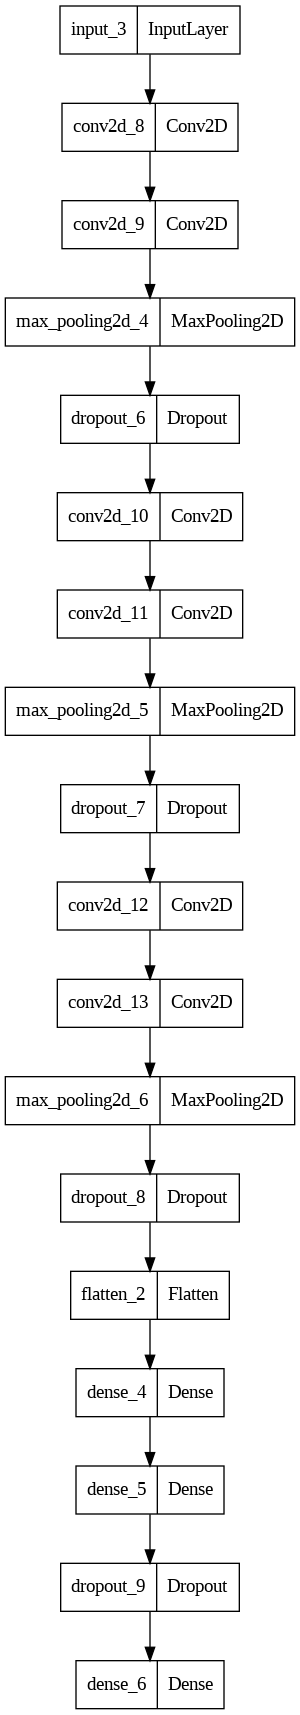

In [18]:
plot_model(model_depth,to_file='depth.png')

In [19]:
history_depth = model_depth.fit(X_train, y_train, batch_size=batch_size, 
                                epochs=epochs, validation_data=(X_test, y_test), verbose=1)

Epoch 1/15
391/391 [==============================] - 10s 16ms/step - loss: 1.8852 - accuracy: 0.2951 - val_loss: 1.4685 - val_accuracy: 0.4551
Epoch 2/15
391/391 [==============================] - 5s 14ms/step - loss: 1.4548 - accuracy: 0.4697 - val_loss: 1.1964 - val_accuracy: 0.5669
Epoch 3/15
391/391 [==============================] - 6s 16ms/step - loss: 1.2633 - accuracy: 0.5460 - val_loss: 1.1169 - val_accuracy: 0.5955
Epoch 4/15
391/391 [==============================] - 6s 15ms/step - loss: 1.1542 - accuracy: 0.5920 - val_loss: 0.9780 - val_accuracy: 0.6498
Epoch 5/15
391/391 [==============================] - 6s 16ms/step - loss: 1.0695 - accuracy: 0.6236 - val_loss: 0.9309 - val_accuracy: 0.6699
Epoch 6/15
391/391 [==============================] - 5s 14ms/step - loss: 1.0119 - accuracy: 0.6476 - val_loss: 0.8803 - val_accuracy: 0.6947
Epoch 7/15
391/391 [==============================] - 6s 16ms/step - loss: 0.9551 - accuracy: 0.6678 - val_loss: 0.9167 - val_accuracy: 0.679

In [20]:
train_loss, train_m = model_depth.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_depth.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('Depth')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 5s - loss: 0.5830 - accuracy: 0.7985 - 5s/epoch - 3ms/step
313/313 - 1s - loss: 0.7237 - accuracy: 0.7496 - 932ms/epoch - 3ms/step
train_loss: 0.5829724073410034, train_accuracy: 0.7985399961471558
test_loss: 0.7236646413803101, test_accuracy: 0.7495999932289124


#### Neural width net with augmentation and batchnormalization

In [21]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=15, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0.2, 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.0)

In [22]:
input_width_b_a = Input(X_train.shape[1:])
x = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(input_width_b_a)
x = BatchNormalization()(x)
x = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), padding='valid')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.25)(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=0.25)(x)
out_width_b_a = Dense(num_classes, activation='softmax')(x)

model_width_b_a = Model(inputs=input_width_b_a, outputs=out_width_b_a)

model_width_b_a.summary()

# model compile
model_width_b_a.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0   

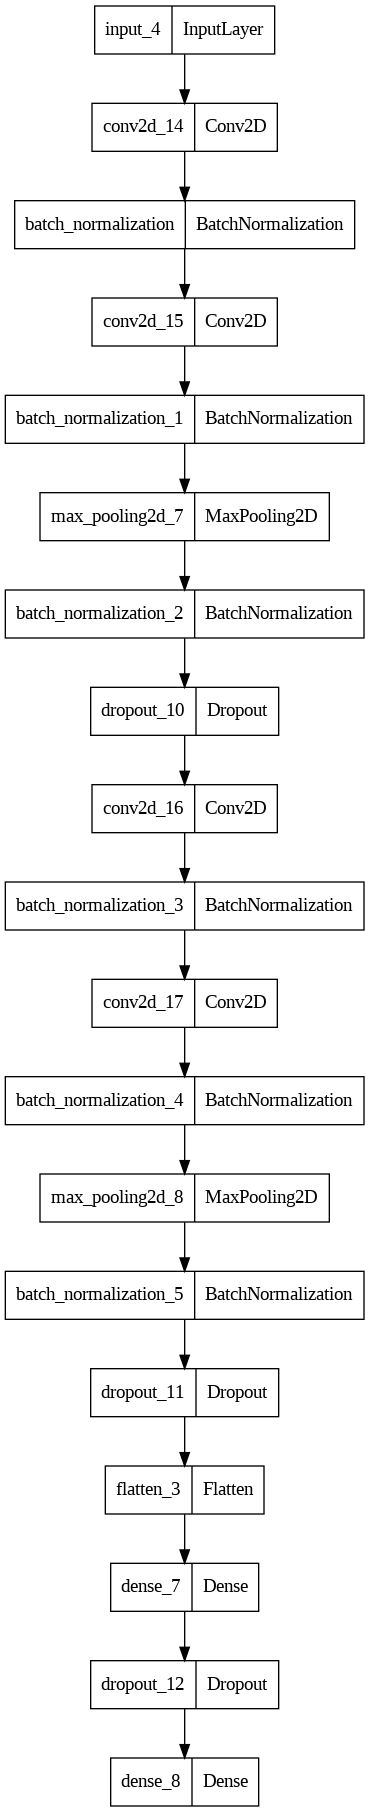

In [23]:
plot_model(model_width_b_a,to_file='width_b_a.png')

In [24]:
model_width_b_a.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size))

<ipython-input-24-d57554718a7f>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_width_b_a.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size))


391/391 [==============================] - 39s 86ms/step - loss: 1.8265 - accuracy: 0.3349


In [25]:
history_width_batch_augmentation = model_width_b_a.fit(X_train, y_train, 
                                                   batch_size=batch_size, 
                                                   epochs=epochs, 
                                                   validation_data=(X_test, y_test), 
                                                   verbose=1)

Epoch 1/15
391/391 [==============================] - 16s 41ms/step - loss: 1.2966 - accuracy: 0.5320 - val_loss: 0.9939 - val_accuracy: 0.6557
Epoch 2/15
391/391 [==============================] - 15s 40ms/step - loss: 1.0697 - accuracy: 0.6207 - val_loss: 0.9389 - val_accuracy: 0.6758
Epoch 3/15
391/391 [==============================] - 16s 41ms/step - loss: 0.9247 - accuracy: 0.6765 - val_loss: 0.9144 - val_accuracy: 0.7021
Epoch 4/15
391/391 [==============================] - 16s 41ms/step - loss: 0.8199 - accuracy: 0.7128 - val_loss: 0.7883 - val_accuracy: 0.7286
Epoch 5/15
391/391 [==============================] - 16s 41ms/step - loss: 0.7199 - accuracy: 0.7473 - val_loss: 0.7075 - val_accuracy: 0.7655
Epoch 6/15
391/391 [==============================] - 15s 39ms/step - loss: 0.6521 - accuracy: 0.7749 - val_loss: 0.6870 - val_accuracy: 0.7762
Epoch 7/15
391/391 [==============================] - 16s 41ms/step - loss: 0.5897 - accuracy: 0.7944 - val_loss: 0.7386 - val_accuracy:

In [26]:
train_loss, train_m = model_width_b_a.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_width_b_a.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('Width_Batch_Augmentation')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 7s - loss: 0.1406 - accuracy: 0.9544 - 7s/epoch - 4ms/step
313/313 - 1s - loss: 0.5985 - accuracy: 0.8247 - 1s/epoch - 4ms/step
train_loss: 0.14064233005046844, train_accuracy: 0.9544000029563904
test_loss: 0.5984951257705688, test_accuracy: 0.8246999979019165


#### Neural net with Resnet50

In [27]:
model_resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(X_train.shape[1:]))
model_resnet50.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                          

In [28]:
model_resnet50.trainable = False

In [29]:
x = GlobalAvgPool2D()(model_resnet50.output)
x = Dropout(rate=0.25)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

model_res = Model(inputs=model_resnet50.input, outputs=x )

In [30]:
# model compile
model_res.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

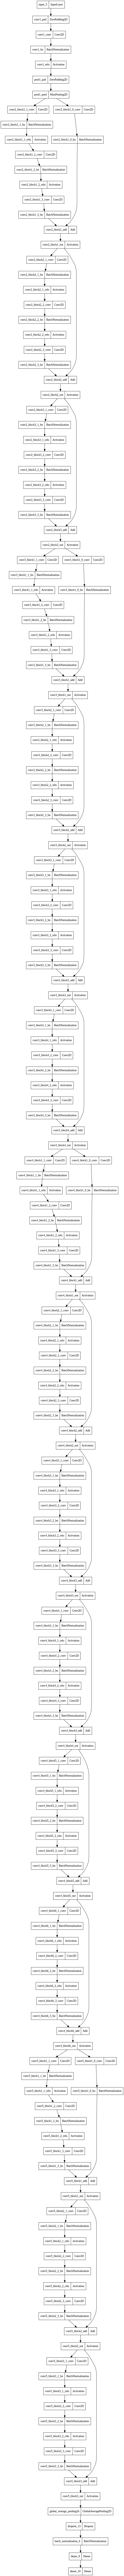

In [31]:
plot_model(model_res,to_file='RESNET50.png')

In [32]:
model_res.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size))

<ipython-input-32-9fb3fd8f2a2e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_res.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size))


391/391 [==============================] - 41s 90ms/step - loss: 2.0649 - accuracy: 0.2439


In [33]:
history_res = model_res.fit(X_train, y_train, 
                            batch_size=batch_size, 
                            epochs=epochs, 
                            validation_data=(X_test, y_test), 
                            verbose=1)

Epoch 1/15
391/391 [==============================] - 14s 35ms/step - loss: 1.9194 - accuracy: 0.3053 - val_loss: 1.8084 - val_accuracy: 0.3676
Epoch 2/15
391/391 [==============================] - 12s 31ms/step - loss: 1.8945 - accuracy: 0.3158 - val_loss: 1.7965 - val_accuracy: 0.3722
Epoch 3/15
391/391 [==============================] - 12s 31ms/step - loss: 1.8716 - accuracy: 0.3248 - val_loss: 1.7892 - val_accuracy: 0.3738
Epoch 4/15
391/391 [==============================] - 11s 28ms/step - loss: 1.8622 - accuracy: 0.3308 - val_loss: 1.7718 - val_accuracy: 0.3825
Epoch 5/15
391/391 [==============================] - 11s 27ms/step - loss: 1.8530 - accuracy: 0.3334 - val_loss: 1.7618 - val_accuracy: 0.3867
Epoch 6/15
391/391 [==============================] - 11s 27ms/step - loss: 1.8430 - accuracy: 0.3393 - val_loss: 1.7759 - val_accuracy: 0.3803
Epoch 7/15
391/391 [==============================] - 11s 27ms/step - loss: 1.8324 - accuracy: 0.3414 - val_loss: 1.7593 - val_accuracy:

In [34]:
train_loss, train_m = model_res.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_res.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('RESNET50_Batch_Augmentation')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 20s - loss: 1.7500 - accuracy: 0.3681 - 20s/epoch - 13ms/step
313/313 - 4s - loss: 1.8197 - accuracy: 0.3419 - 4s/epoch - 12ms/step
train_loss: 1.7499712705612183, train_accuracy: 0.36814001202583313
test_loss: 1.819680094718933, test_accuracy: 0.3418999910354614


#### Fully connected network

In [35]:
# конфигурирование слоев нейросети
input_full = Input(X_train.shape[1:])

# полносвязные слои нейронной сети
x = Flatten()(input_full)
x = Dense(512, activation = 'relu')(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
out_full = Dense(num_classes, activation='softmax')(x)

model_full = Model(inputs=input_full, outputs=out_full)

# компиляция модели
model_full.compile(optimizer='Adam', 
                   loss=tf.keras.losses.CategoricalCrossentropy(), 
                   metrics=['accuracy'])
history_full = model_full.fit(X_train, y_train, 
                             batch_size=batch_size, 
                             epochs=epochs, 
                             validation_data=(X_test, y_test), 
                             verbose=1)


Epoch 1/15
391/391 [==============================] - 4s 7ms/step - loss: 2.0215 - accuracy: 0.2611 - val_loss: 1.8008 - val_accuracy: 0.3544
Epoch 2/15
391/391 [==============================] - 3s 7ms/step - loss: 1.8079 - accuracy: 0.3517 - val_loss: 1.6850 - val_accuracy: 0.3946
Epoch 3/15
391/391 [==============================] - 2s 5ms/step - loss: 1.7285 - accuracy: 0.3830 - val_loss: 1.6518 - val_accuracy: 0.4116
Epoch 4/15
391/391 [==============================] - 2s 5ms/step - loss: 1.6643 - accuracy: 0.4076 - val_loss: 1.6033 - val_accuracy: 0.4293
Epoch 5/15
391/391 [==============================] - 2s 5ms/step - loss: 1.6309 - accuracy: 0.4196 - val_loss: 1.5398 - val_accuracy: 0.4561
Epoch 6/15
391/391 [==============================] - 2s 5ms/step - loss: 1.5902 - accuracy: 0.4352 - val_loss: 1.5497 - val_accuracy: 0.4444
Epoch 7/15
391/391 [==============================] - 2s 6ms/step - loss: 1.5615 - accuracy: 0.4454 - val_loss: 1.4985 - val_accuracy: 0.4669
Epoch 

In [36]:
train_loss, train_m = model_full.evaluate(X_train, y_train, verbose=2)
test_loss, test_m = model_full.evaluate(X_test, y_test, verbose=2)
print(f'train_loss: {train_loss}, train_accuracy: {train_m}')
print(f'test_loss: {test_loss}, test_accuracy: {test_m}')

net_name.append('Fully connected network')
train_accuracy.append(round(train_m, 2))
test_accuracy.append(round(test_m, 2))

1563/1563 - 4s - loss: 1.3644 - accuracy: 0.5080 - 4s/epoch - 2ms/step
313/313 - 1s - loss: 1.4532 - accuracy: 0.4824 - 1s/epoch - 3ms/step
train_loss: 1.364410161972046, train_accuracy: 0.5079799890518188
test_loss: 1.4532426595687866, test_accuracy: 0.48240000009536743


#### Result

In [37]:
result['net_name'] = net_name
result['train_accuracy'] = train_accuracy
result['test_accuracy'] = test_accuracy
result.sort_values(by=['test_accuracy'], axis=0, ascending=True, inplace=True)
result

,net_name,train_accuracy,test_accuracy
4,RESNET50_Batch_Augmentation,0.37,0.34
5,Fully connected network,0.51,0.48
2,Depth,0.80,0.75
0,Basic,0.83,0.76
1,Width,0.87,0.77
3,Width_Batch_Augmentation,0.95,0.82


#### Вывод:
- увеличение глубины сети не дало никакого результата (метрика даже немного уменьшилась);
- увеличение ширины сети дало незначительное увеличение метрики;
- увеличение ширины сети с использованием аугиентации и пакетной нормализации позволило добиться значительного прироста в производительности и стабильности работы сети по сравнению с базовой моделью;
- полносвязанная модель и модель с использованием ResNet50 показали низкое качество.